LDA Topic Modeling
---

Preforming LDA topic modeling with R&R terms.

### Imports

In [1]:
# processing
import operator
from operator import methodcaller
import csv
import re
import numpy as np
import pandas as pd
from pprint import pprint
import string
import math
import itertools
import sqlite3
import copy

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import HdpModel
from gensim.models import TfidfModel

# plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


C:\Users\pjz1\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Preprocessing

Read in the output from the R&R program. Tokenize the terms and remove blacklisted tokens. Build a corpora.

In [2]:
# path to blacklisted tokens
blacklist = [t.strip() for t in next(csv.reader(open("tools\\blacklist.csv", 'r')))]

# levels of R&R terms considered
levels = [0, 1, 2, 3]

# format [term, orig, sentence, docID]
inPath = "v2.csv"
inFile = open(inPath, 'r')
inReader = csv.reader(inFile)

In [3]:
docTokens = dict()

# ignore headers
next(inReader)

for inRow in inReader:
    term = inRow[0]
    sentence = inRow[2]
    docID = inRow[3]
    
    # find acceptable tokens only
    token = "_".join([t for t in term.split(":") if re.match(r'[^\W\d]*$', t) and not t in blacklist])

    # calculate new term level
    level = token.count("_")

    # if acceptable, add to dictionary
    if level in levels and not token in blacklist and len(token) > 0:
        if docID in docTokens:
            docTokens[docID] += [token]
        else:
            docTokens[docID] = [token]

# compile all IDs and texts
docIDs = list(docTokens.keys())
texts = list(docTokens.values())

In [16]:
# build a dictionary for the text
dictionary = corpora.Dictionary(texts)
print("Raw dictionary: " + str(len(dictionary)) + " terms")

# filter out terms that appear in fewer that LOW docs or greater than HIGH percent of docs and use KEEP terms
LOW = 1
HIGH = 0.08
KEEP = 10000

old_dict = copy.copy(dictionary)

dictionary.filter_extremes(no_below = LOW, no_above = HIGH, keep_n = KEEP)
print("Filtered dictionary: " + str(len(dictionary)) + " terms")


# convert the text to a corpus with the dictionary
corpus = [dictionary.doc2bow(text) for text in texts]



Raw dictionary: 17789 terms
Filtered dictionary: 10000 terms


### Modeling

Standard LDA modeling. Toggle the number of topics, passes, and iterations.

In [5]:
def model(corpus, numtop, passes, iterations):

    # run LDA with four cores
    model = gensim.models.LdaMulticore(corpus, 
                                       num_topics=numtop, 
                                       id2word=dictionary,
                                       passes=passes, 
                                       workers=4,
                                       iterations=iterations)

    return model    

Perform a set of trials and write results to files.

In [ ]:
# folder to write databases to
STEM = "databases\\"

# set range of passes and topics to test
passes = []
topics = []

for p in passes:
    for t in topics:
        
        # create database
        con = sqlite3.connect(STEM + "topics_p" + str(p+"_t"+str(t)+".db"))
        cur = con.cursor()
        
        # train model
        print("Training LDA...")
        model = model(corpus, p, t, 500)           
        print("Done.")
                              
        # write the topic-terms table
        print("Writing topics to terms...")

        cur.execute("""
            CREATE TABLE IF NOT EXISTS TERMS
                (topic INT,
                term TEXT,
                prob FLOAT)
        """)

        for i in range(lda_model.num_topics):
            topics = lda_model.show_topic(i, topn = 20)
            for t in topics:
                cur.execute("INSERT INTO TERMS (topic, term, prob) VALUES (?, ?, ?)", [i+1, t[0], t[1]])

        print("Done.")
                              
        # write the doc-topics table
        print("Writing doc to topics...")

        cur.execute("""
            CREATE TABLE IF NOT EXISTS DOCS
                (doc TEXT,
                topic INT,
                prob FLOAT)
        """)

        for ID in docIDs:

            doc = docTokens[ID]
            store = list(model.get_document_topics(dictionary.doc2bow(doc)))

            for pair in store:

                cur.execute("INSERT INTO DOCS (doc, topic, prob) VALUES (?, ?, ?)", [docID, pair[0], pair[1]])

        print("Done.")


In [17]:
normalmodel = model(corpus, 10, 2, 500)
for topic in normalmodel.print_topics():
    phrase = str(topic[1])
    topics = ", ".join([t for t in phrase.split("\"") if not "*" in t and not t.strip()==""])
    print(topics + "\n\n")

n_h, chain, water, conformation, water_molecule, axis, anion, asymmetric_unit, cation, o_h


ray, x_ray, datum, method, diffraction, resolution, minus, result, space_group, space


complex, acid, c, inversion, geometry, o_h, sequence, plane, centre, cation


pi, geometry, ray, datum, system, distance, diffraction, complex, parameter, method


region, asymmetric_unit, study, c_h, chain, method, type, position, sequence, address


ray, datum, x_ray, gene, method, information, complex, position, system, lattice


ray, type, complex, asymmetric_unit, site, method, resolution, calculation, x_ray, diffraction


c_h, dihedral_angle, ray, conformation, benzene, benzene_ring, chain, pi, minus, intermolecular_n_h


c_h, ray, pi, c, dihedral_angle, weak_c_h, x_ray, pi_interaction, plane, system


complex, prime, study, chain, cation, anion, plane, geometry, network, system




Perform cyclical tests, with a lower bound.

In [6]:
def cyclic(minp, rat, p, its):
    
    done = False
    newcorpus = copy.copy(corpus)
    newIDs = docIDs.copy()
    totalTopics = 0
    
    while not done:
        
        t = math.ceil(len(newcorpus) * rat)
        totalTopics += t
        
        newmodel = model(newcorpus, t, p, its)
        
        print(newmodel.print_topics())
        
        badIDs = list()
        
        for ID in newIDs:
            doc = docTokens[ID]
            store = list(newmodel.get_document_topics(dictionary.doc2bow(doc), minimum_probability = minp))
            
            if len(store) == 0:
                badIDs.append(ID)
        
        if len(badIDs) == 0:
            done = True
            
        else:
            newIDs = badIDs
            newcorpus = [dictionary.doc2bow(docTokens[ID]) for ID in newIDs]
            print(len(badIDs))
            
    print("Total topics: " + str(totalTopics))

In [7]:
cyclic(0.85, 0.005, 100, 500)

[(0, '0.002*"n_h" + 0.002*"o_hydrogen_bond" + 0.002*"asymmetric_unit" + 0.002*"benzene_ring" + 0.001*"o_h" + 0.001*"c_h" + 0.001*"intermolecular_hydrogen_bond" + 0.001*"water_molecule" + 0.001*"dihedral_angle" + 0.001*"independent_molecule"'), (1, '0.003*"asymmetric_unit" + 0.002*"n_atom" + 0.001*"asymmetric_unit_molecule" + 0.001*"aromatic_pi" + 0.001*"dihedral_angle" + 0.001*"c_h" + 0.001*"space_group" + 0.001*"o_atom" + 0.001*"phenyl_ring" + 0.001*"weak_intermolecular_c_h"'), (2, '0.003*"o_hydrogen_bond" + 0.003*"n_h" + 0.003*"c_h" + 0.003*"c_o" + 0.003*"o_h" + 0.003*"n_hydrogen_bond" + 0.003*"c_o_h" + 0.003*"c_n_h" + 0.002*"asymmetric_unit" + 0.002*"n_o_h"'), (3, '0.002*"c_h" + 0.002*"intermolecular_c_h" + 0.002*"intermolecular_n_h" + 0.002*"o_h" + 0.002*"o_hydrogen_bond" + 0.002*"dihedral_angle" + 0.002*"weak_intermolecular_c_h" + 0.002*"n_h" + 0.002*"pi_pi" + 0.001*"sn_atom"'), (4, '0.003*"weak_c_h" + 0.002*"c_h" + 0.002*"dihedral_angle" + 0.002*"pi_interaction" + 0.002*"ring_sys

### Output Topics

### Coherence Testing

Test a range for the ideal number of topics.

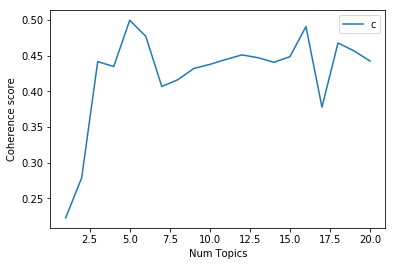

In [20]:
topics = range(1, 21)
passes = 5
iterations = 500

model_list = list()
coherence_values = list()

for topicnum in topics:

    model = gensim.models.LdaMulticore(corpus, num_topics=topicnum, id2word=dictionary, passes=passes, workers =4, iterations=iterations)
    model_list.append(model)
    
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


plt.plot(topics, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Visualization

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(normalmodel, corpus, dictionary)